# Importing libraries

In [ ]:
!pip install torchmetrics

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

from torchmetrics import Dice

# Checking device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# Downloading and working with dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_dir = os.path.join("/content/gdrive/MyDrive/cityscapes_data/cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


/content/gdrive/MyDrive/cityscapes_data/cityscapes_data/train/2571.jpg


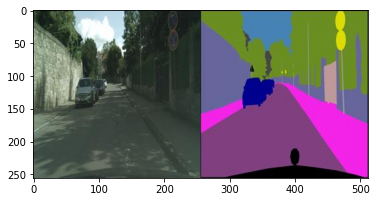

In [6]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

Images in dataset are merged with their respective masks, so I need to split them as a part of augmentation.

In [7]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
3 255 0 255


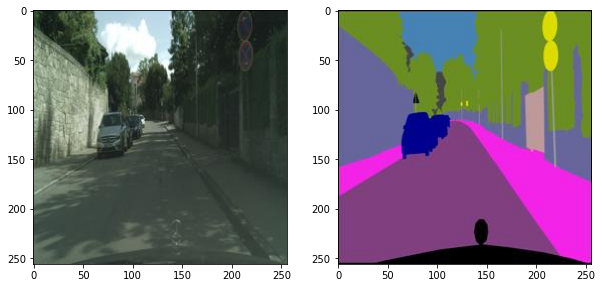

In [8]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

# Creating labels for classes in images

In [9]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[128 233 132]
 [ 27 222 147]
 [ 63  98 234]
 [238 217  17]
 [ 15 234  18]]


In [10]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [11]:
label_model.predict(color_array[:5, :])

array([8, 8, 2, 0, 4], dtype=int32)

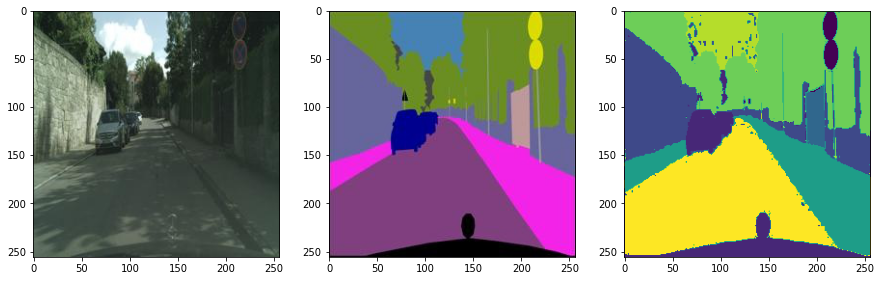

In [12]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [13]:
label_class

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 7, 7, ..., 7, 7, 1],
       [1, 7, 7, ..., 7, 7, 7],
       ...,
       [1, 1, 1, ..., 5, 5, 9],
       [1, 1, 1, ..., 9, 9, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

# Creating Dataset class for loading and augmenting images

In [14]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [15]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [16]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


# Building model with U-net structure

U-net is a machine learning model architectrue, which consists of contracting and expansive path. 
First follows typical atchitecture of convolutional neural network and is used to downsample the image. 
Every step in expansive part consists of upsampling the image.

In [17]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.con_11 = self.conv_block(in_channels=3, out_channels=64)
        self.con_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.con_21 = self.conv_block(in_channels=64, out_channels=128)
        self.con_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.con_31 = self.conv_block(in_channels=128, out_channels=256)
        self.con_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.con_41 = self.conv_block(in_channels=256, out_channels=512)
        self.con_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.center = self.conv_block(in_channels=512, out_channels=1024)
        self.exp_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.exp_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.exp_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.exp_22 = self.conv_block(in_channels=512, out_channels=256)
        self.exp_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.exp_32 = self.conv_block(in_channels=256, out_channels=128)
        self.exp_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.exp_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        con_11_out = self.con_11(X) # [-1, 64, 256, 256]
        con_12_out = self.con_12(con_11_out) # [-1, 64, 128, 128]
        con_21_out = self.con_21(con_12_out) # [-1, 128, 128, 128]
        con_22_out = self.con_22(con_21_out) # [-1, 128, 64, 64]
        con_31_out = self.con_31(con_22_out) # [-1, 256, 64, 64]
        con_32_out = self.con_32(con_31_out) # [-1, 256, 32, 32]
        con_41_out = self.con_41(con_32_out) # [-1, 512, 32, 32]
        con_42_out = self.con_42(con_41_out) # [-1, 512, 16, 16]
        center_out = self.center(con_42_out) # [-1, 1024, 16, 16]
        exp_11_out = self.exp_11(center_out) # [-1, 512, 32, 32]
        exp_12_out = self.exp_12(torch.cat((exp_11_out, con_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        exp_21_out = self.exp_21(exp_12_out) # [-1, 256, 64, 64]
        exp_22_out = self.exp_22(torch.cat((exp_21_out, con_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        exp_31_out = self.exp_31(exp_22_out) # [-1, 128, 128, 128]
        exp_32_out = self.exp_32(torch.cat((exp_31_out, con_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        exp_41_out = self.exp_41(exp_32_out) # [-1, 64, 256, 256]
        exp_42_out = self.exp_42(torch.cat((exp_41_out, con_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(exp_42_out) # [-1, num_classes, 256, 256]
        return output_out

# Setting some configurations

In [18]:
model = UNet(num_classes=num_classes)

In [19]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

dataiter = iter(data_loader)
X, Y = next(dataiter)
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [20]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [21]:
batch_size = 16

epochs = 10
lr = 0.01

In [22]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [23]:
model = UNet(num_classes=num_classes).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training the model

In [26]:
step_losses = []
epoch_losses = []
step_dices = []
epoch_dices = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_dice = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        dice = Dice(average='micro').to(device)
        dice_i = dice(Y_pred, Y)
        epoch_dice += dice_i.cpu()
        step_dices.append(dice_i.cpu())
    epoch_dices.append(dice_i.cpu()/len(data_loader))
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

# Plotting loss and dice per step and epoch

Text(0.5, 1.0, 'Epoch dice')

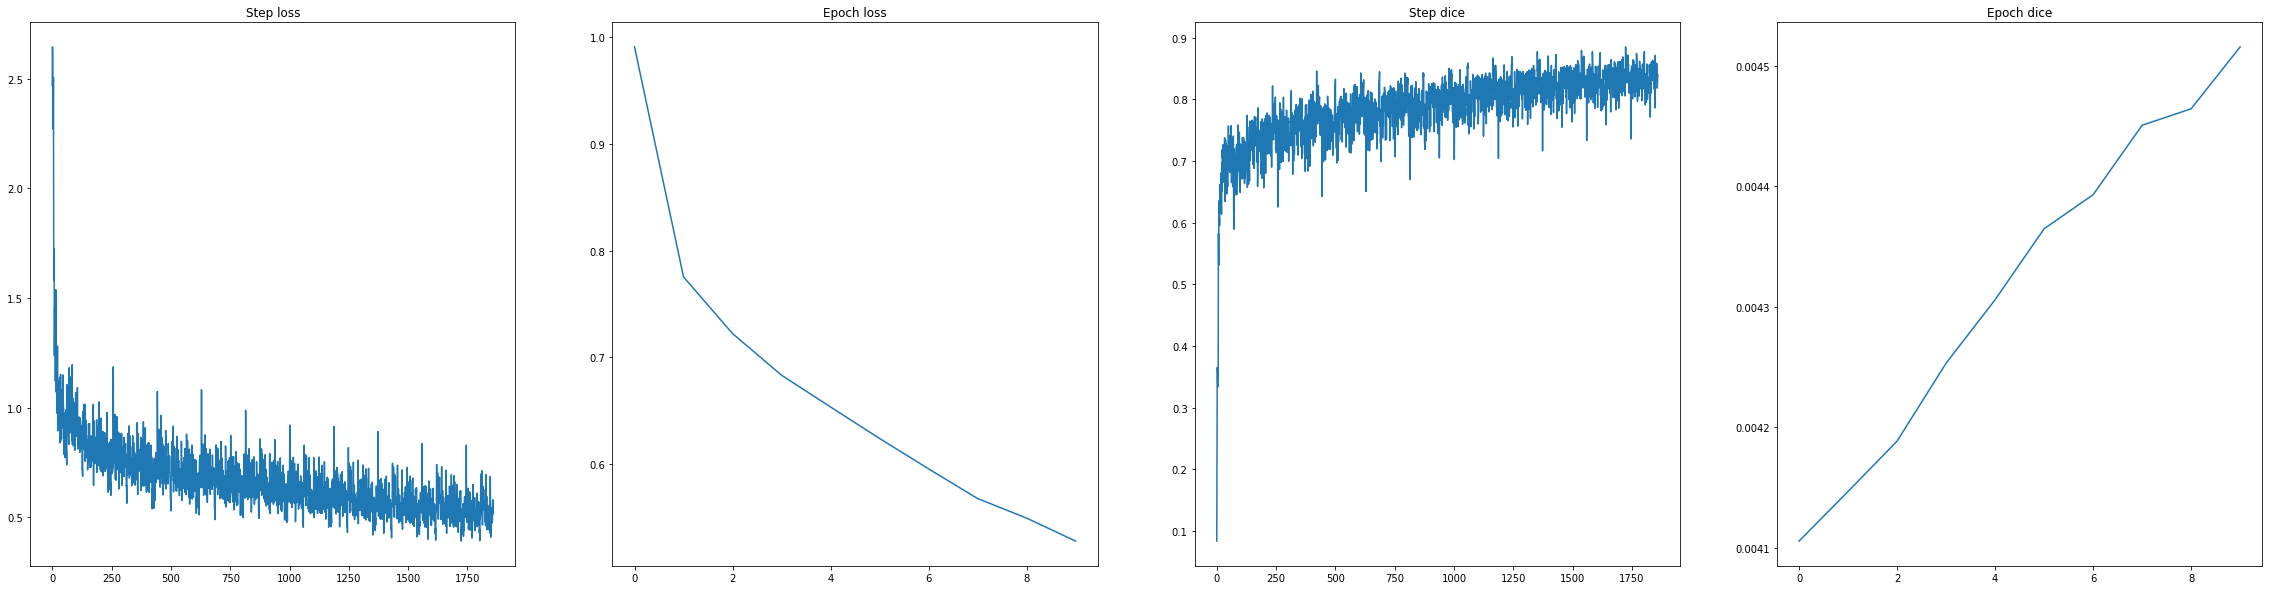

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
axes[0].plot(step_losses)
axes[0].set_title('Step loss')
axes[1].plot(epoch_losses)
axes[1].set_title('Epoch loss')
axes[2].plot(step_dices)
axes[2].set_title('Step dice')
axes[3].plot(epoch_dices)
axes[3].set_title('Epoch dice')

Losses both per step and per epoch go down with time, which means that model is training well. 
Dice coefficient is used as a measure in image segmentation machine learning and is used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.
Dice coefficient is 2 times the area of Overlap divided by the total number of pixels in both the images. The best it can be is 1.0, so dice coefficient rising over steps and epoch also means that model is doing well.

# Saving model

In [28]:
model_name = "/content/gdrive/MyDrive/cityscapes_data/cityscapes_data/U-Net.pth"
torch.save(model.state_dict(), model_name)

# Testing model

In [29]:
model_path = "/content/gdrive/MyDrive/cityscapes_data/cityscapes_data/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [31]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [32]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

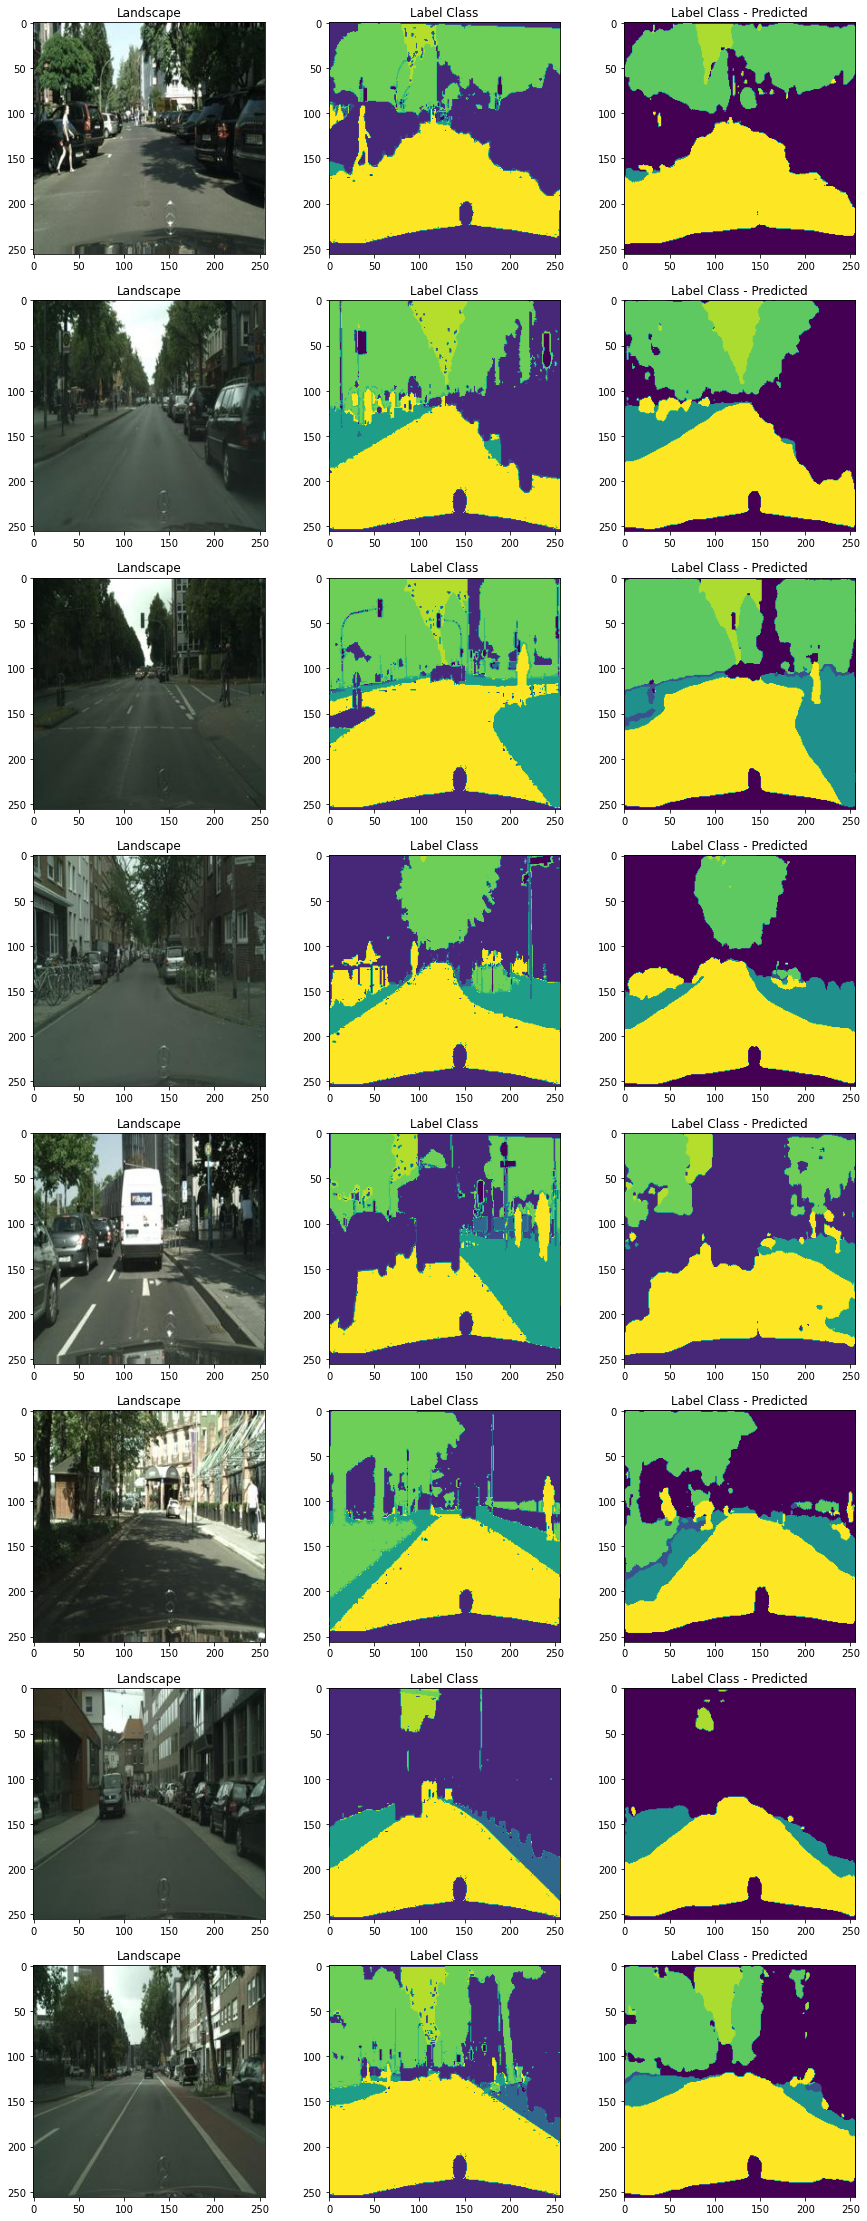

In [33]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

Model seems to have done pretty well in recognizing roads and closest cars.